In [5]:
import numpy as np
from matplotlib import pyplot as plt
from utils import CarTrajectoryNonLinear, UKF, plot_trajectory, conf_ellipse

from numpy.random import uniform
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats
from tqdm import tqdm
from scipy.stats import multivariate_normal as mvn

from matplotlib import animation, rc


import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.stats
import numpy as np
from tqdm import tqdm

In [6]:
system = CarTrajectoryNonLinear()
states, measurements = system.get_data()

f = system.f
F_jacobian = system.F_jacobian
h = system.h
H_jacobian = system.H_jacobian
Q = system.Q
R = system.R

In [7]:
extended_kalman_filter = UKF(f, h, Q, R, dim_m = 4, dim_y = 2)
state_estimates, cov_estimates = extended_kalman_filter.filter(measurements)
state_estimates_smoothed, cov_estimates_smoothed = extended_kalman_filter.smoother(state_estimates, cov_estimates)

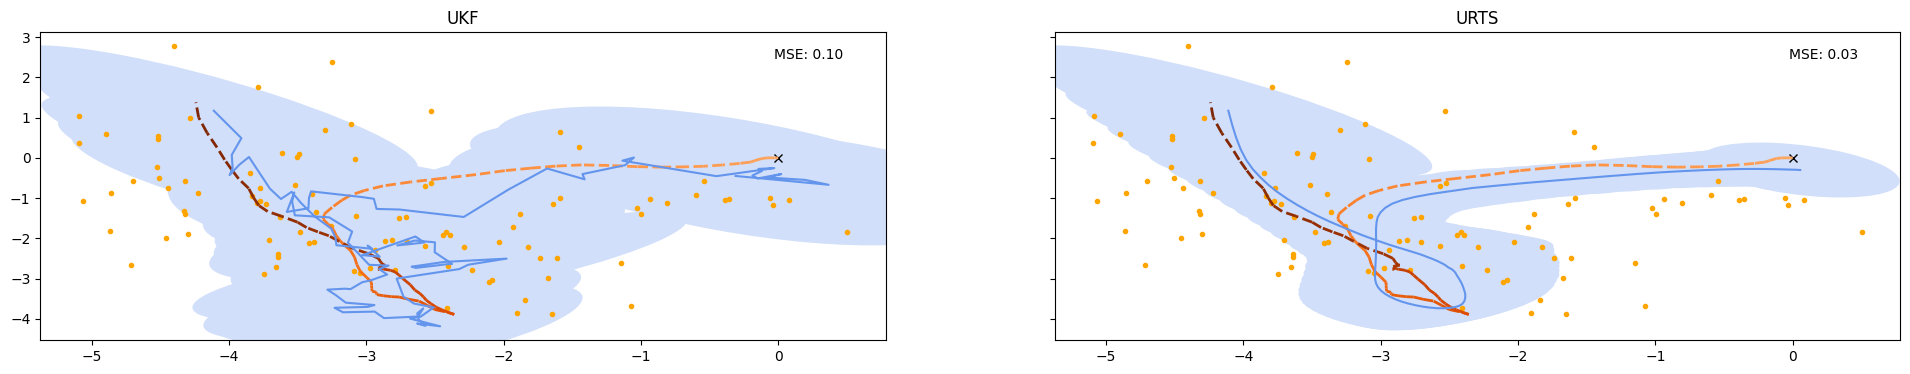

In [8]:
from matplotlib.collections import LineCollection
from matplotlib.cm import get_cmap

#Compare methods
fig, ax = plt.subplots(1, 2, figsize=(24, 4), sharey=True)

for k in range(2):
    ax[k].plot(states[0, 0], states[0, 1], 'x', color='k', label="Start")
    #ax[k].plot(states[:, 0], states[:, 1], '--', color='orange', label="True trajectory")
    ax[k].plot(measurements[:, 0], measurements[:, 1], '.', color='orange', label="Noisy observations")
    
# Create a set of line segments
points = np.array([states[:, 0], states[:, 1]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
oranges = get_cmap('Oranges')(np.linspace(0.4, 1, len(segments)))
lc1 = LineCollection(segments, colors=oranges, linewidths=2, linestyle='--', label="True trajectory")
lc2 = LineCollection(segments, colors=oranges, linewidths=2, linestyle='--', label="True trajectory")

# Plot line
ax[0].add_collection(lc1)
ax[1].add_collection(lc2)
    
plot_trajectory(ax[0], state_estimates, cov_estimates, label="UKF")
ax[0].set_title("UKF")

plot_trajectory(ax[1], state_estimates_smoothed, cov_estimates_smoothed, label="URTS")
ax[1].set_title("URTS")

# Show the MSE on the plot in upper right corner
ax[0].text(0.95, 0.95, "MSE: {:.2f}".format(np.mean((states[:, :2] - state_estimates[:, :2])**2)),
           horizontalalignment='right', verticalalignment='top', transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, "MSE: {:.2f}".format(np.mean((states[:, :2] - state_estimates_smoothed[:, :2])**2)),
           horizontalalignment='right', verticalalignment='top', transform=ax[1].transAxes)

plt.show()

In [14]:
state_estimates_smoothed.shape

(100, 4)

100%|██████████| 200/200 [00:32<00:00,  6.13it/s]


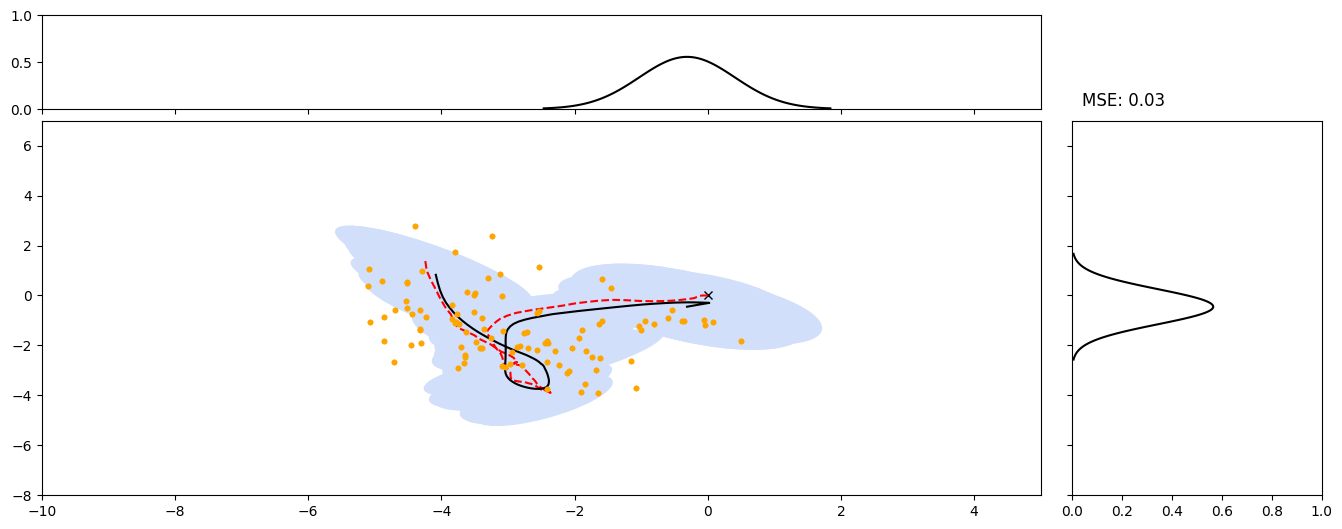

In [16]:
extended_animation = PlotAnimation(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, name="animations/extented_kalman_filter")
extended_animation.animate()